# **런던자전거수요예측(시계열 딥러닝)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')           
!ls /content/drive/MyDrive/data/

Mounted at /content/drive
data1.csv  gpascore.csv  london_merged.csv


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
df = pd.read_csv("./drive/MyDrive/data/london_merged.csv", parse_dates=['timestamp']) # 시계열로 인식
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [99]:
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [100]:
df.shape

(17414, 10)

In [101]:
train = df.iloc[:17000, 1:2]
test = df.iloc[17000:17414, 1:2]
print(train.shape)
print(test.shape)

(17000, 1)
(414, 1)


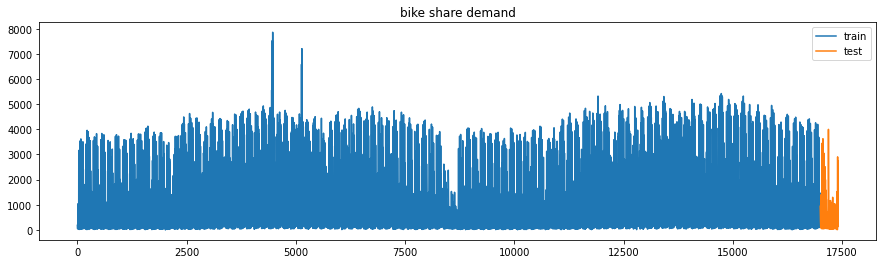

In [102]:
df['cnt'][:17000].plot(figsize=(15, 4), legend=True)
df['cnt'][17000:].plot(figsize=(15, 4), legend=True)
plt.legend(['train', 'test'])
plt.title('bike share demand')
plt.show()

# **시계열 데이터의 차수 추정**
어떤 대상이 가진 성질의 정도를 나타내는 것으로 쓰임

In [103]:
# 차수를 추정
from statsmodels.tsa.stattools import pacf

pacf = pacf(df['cnt'], nlags=20, method='ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713]


<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

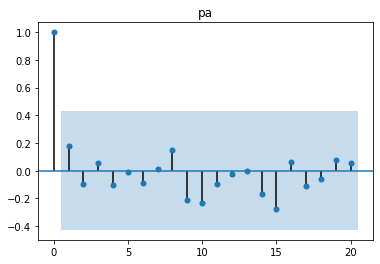

In [104]:
# 시계열 데이터의 차수를 추정하는 방법
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=20, method='ols', title='pa').show

시간당 차수를 확인하여 다음시간의 바이크 이용수를 예측하는 모형을 만들예정

# **Scale** (min max Scaler)

In [105]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) # 0 ~ 1 사이값으로 변환
train_scaled = sc.fit_transform(train)
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [106]:
# 1시간전 데이터를 독립변수로
x_train = []
y_train = []

for i in range(1, 17000):
    x_train.append(train_scaled[i-1 : i, 0])
    y_train.append(train_scaled[i, 0])

# numpy로 변경
x_train, y_train = np.array(x_train), np.array(y_train)

# 시계열 딥러닝은 3차원데이터를 필요로함
x_train # 2차원 배열임
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(16999, 1, 1)

# **RNN**

* 과거의 입력값을 보관하여 출력에 영향을 미침
* RNN은 이전 타임 스텝에서의 어떠한 정보(hidden state)를 다음 타임스텝으로 계속 전달하여 연산하는 방식
* 하지만 RNN의 경우 시퀀스가 너무 길다면 앞 쪽의 타임 스텝의 정보가 뒤의 타입스텝까지 충분히 전달되지 못하는 장기의존성 문제(long-term dependecies) 가있음

In [107]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN

rnn = Sequential()
rnn.add(SimpleRNN(activation='relu', units=6, input_shape=(1,1)))
rnn.add(Dense(activation='linear', units=1))

In [108]:
print(rnn.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 6)                 48        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


## **모델 컴파일**

In [109]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

## **모델 학습**

In [110]:
rnn.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 55s 3ms/step - loss: 0.0071 - mse: 0.0071
Epoch 2/2
16999/16999 [==============================] - 54s 3ms/step - loss: 0.0068 - mse: 0.0068


In [111]:
inputs  = sc.transform(test)
inputs.shape

(414, 1)

In [112]:
x_test = []
for i in range(1, 415):
    x_test.append(inputs[i-1:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(414, 1, 1)

In [113]:
rnn = rnn.predict(x_test)
rnn = sc.inverse_transform(rnn) # 일반화한 데이터를 다시 돌려서 넣는다

In [114]:
test1 = pd.DataFrame(test)
rnn1 = pd.DataFrame(rnn)

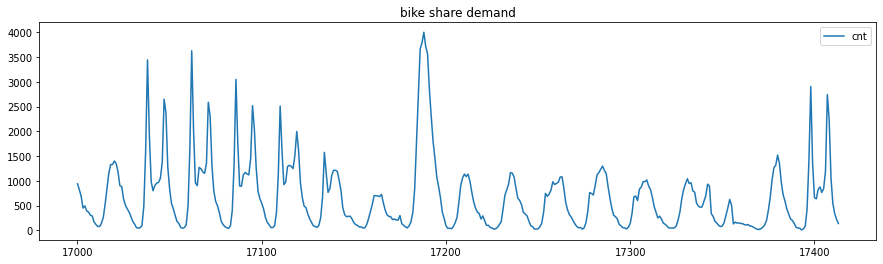

In [115]:
test1.plot(figsize=(15, 4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

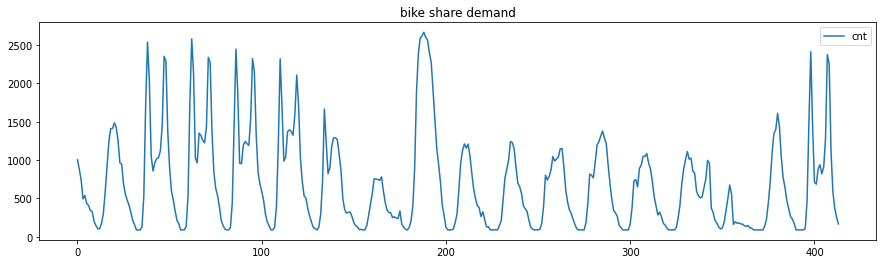

In [116]:
rnn1.plot(figsize=(15, 4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

In [117]:
test = np.array(test)

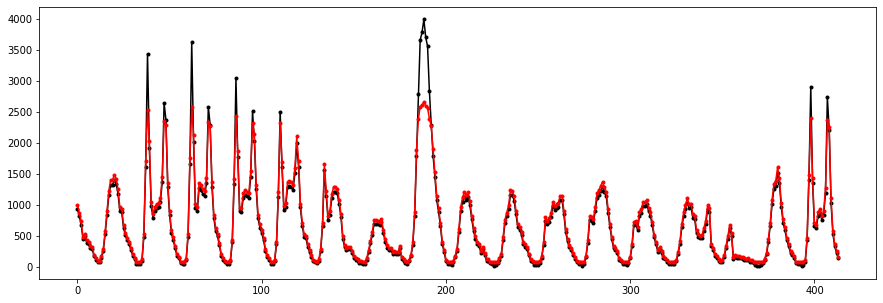

In [118]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker='.', label='RNN', color='red')

# **LSTM**
*  LSTM은 hidden state만이 아니라 cell state라는 역할이 있으며 Forget gate, Input gate, Output gate를 통해 계산
* Cell state는 hidden state와 마찬가지로 이전 시점의 cell state를 다음 시점으로 넘겨줌
* Cell state의 주 역할은 gate들과 함께 작용하여 정보를 선택적으로 활용
* forget gate는 과거 정보를 기억할지 잊을지를 결정하는 단계
* input gate는 '현재 정보를 잊기/기억하기'를 위한 단계





In [119]:
from keras.layers.recurrent import LSTM
lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1,1)))
lstm.add(Dense(units=1, activation='linear'))
lstm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


## **모델 컴파일**

In [120]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])

## **모델 학습**

In [121]:
lstm.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 81s 5ms/step - loss: 0.0082 - mse: 0.0082
Epoch 2/2
16999/16999 [==============================] - 79s 5ms/step - loss: 0.0068 - mse: 0.0068


In [122]:
lstm = lstm.predict(x_test)
lstm = sc.inverse_transform(lstm)

<function matplotlib.pyplot.legend>

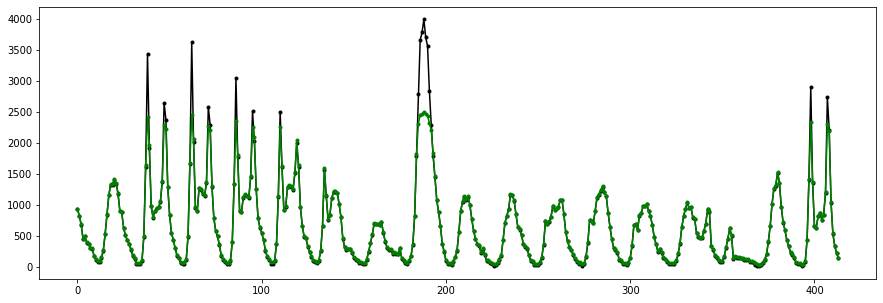

In [123]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(lstm, marker='.', label='LSTM', color='green')
plt.legend

# **GRU**
* GRU에서는 reset gate, update gate 2개의 gate만을 사용
* 또한 cell state, hidden state가 합쳐져 하나의 hidden state로 표현
* update gate는 과거와 현재의 정보를 각각 얼마나 반영할지에 대한 비율을 구하는 것이 핵심
* GRU는 기존 LSTM에 비해 더 간단한 구조를 가지고 있습니다. 그리고 마지막 출력값에 활성화함수를 적용하지 않음. 
* 성능 면에서는 LSTM과 비교해서 우월하다고 할 수 없지만 학습할 파라미터가 더 적은 것이 장점이라고 할 수 있습니다.




In [124]:
ㄴfrom keras.layers.recurrent import GRU
gru = Sequential()
gru.add(GRU(units=6, activation = 'relu', input_shape=(1,1)))
gru.add(Dense(units=1, activation = 'linear'))
gru.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 6)                 144       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


## **모델 컴파일**

In [125]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])

## **모델 학습**

In [126]:
gru.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 76s 4ms/step - loss: 0.0075 - mse: 0.0075
Epoch 2/2
16999/16999 [==============================] - 74s 4ms/step - loss: 0.0068 - mse: 0.0068


In [127]:
gru = gru.predict(x_test)
gru = sc.inverse_transform(gru)

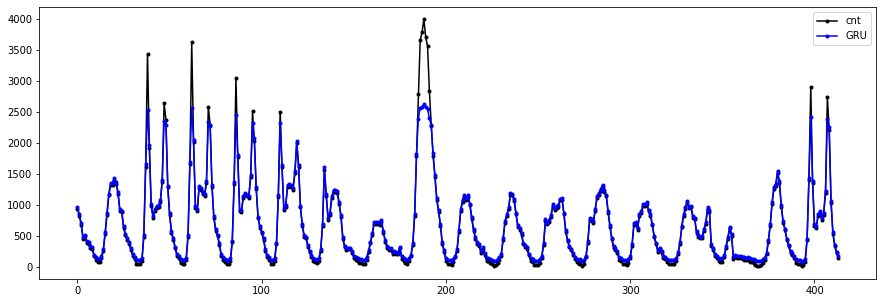

In [128]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(gru, marker='.', label='GRU', color='blue')
plt.legend()

# **모형별 비교**
(RNN, LSTM, GRU)

RNN < GRU, LSTM 순서로 정확도가 좋읍

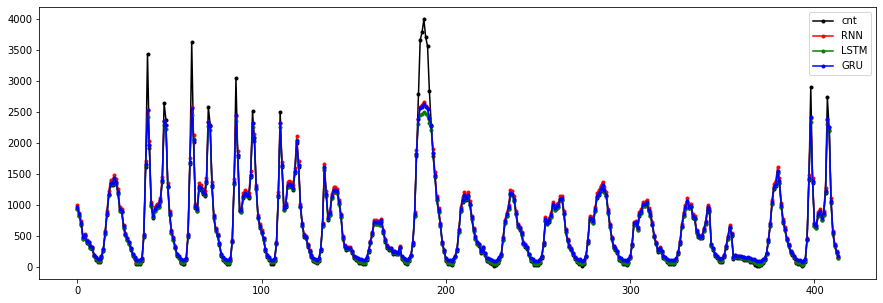

In [134]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker='.', label='RNN', color='red')
plt.plot(lstm, marker='.', label='LSTM', color='green')
plt.plot(gru, marker='.', label='GRU', color='blue')
plt.legend()

In [135]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [131]:
print('RNN RMSE : ', RMSE(test, rnn))
print('LSTM RMSE : ', RMSE(test, lstm))
print('GRU RMSE : ', RMSE(test, gru))

RNN RMSE :  162.02996413337377
LSTM RMSE :  174.17709812797105
GRU RMSE :  160.11415159618025
